# Short and Long Term Energy Model - Isle of Eigg

##### Created on: 25.12.2023
##### Last updated on: 17.01.2024
##### File Revision: 01

##### Developed by: Taha Ahmed Siddiqui (tahaahmedsiddiqui@outlook.com) and Hareem Taha (hareem.nadeem10@gmail.com)
##### GitHub Repository: https://github.com/TahaAhmedSiddiqui/Energy-Modelling---Isle-of-Eigg

### 1. Base Case

##### (With current capacities and no new installed capacities, we look at the emissions and the demand not covered)

##### Enter your code here and before 2. for Base Case

In [35]:
#Import relevant packages here

import pyomo.environ as pyo
import pandas as pd
import matplotlib.pyplot as plt

In [36]:
#Initiate the model

#Naming the model 'EM' -- stands for Energy Model
EM = pyo.AbstractModel()

#### Sets

In [37]:
#Call the data from input csv's and generate sets
#The model iterates over a set of technologies, a set of storages, and a set of fuels that connects the two and serves the demand

#Reading the csv's
technology = pd.read_csv('../1. Input/technologies.csv')
fuel = pd.read_csv('../1. Input/fuels.csv')
storage = pd.read_csv('../1. Input/storages.csv')

#Creating sets
EM.Technology = pyo.Set(initialize = technology['technology'])
EM.Fuel = pyo.Set(initialize = fuel['fuel'])
EM.Storage = pyo.Set(initialize = storage['storage'])
EM.Hour = pyo.RangeSet(1,8760,1)

#### Parameters

In [38]:
#Call the data from input csv's and generate parameters
#The model has the installed capacities of technologies and storages, their conversion ratios and efficiencies, and a demand profile

#Reading the csv's
readin_variablecost = pd.read_csv('../1. Input/variablecost.csv', index_col=[0], sep=',').squeeze('columns')
readin_inputratio = pd.read_csv('../1. Input/inputratio.csv', index_col=[0,1], sep=',').squeeze('columns')
readin_outputratio = pd.read_csv('../1. Input/outputratio.csv', index_col=[0,1], sep=',').squeeze('columns')
readin_demand = pd.read_csv('../1. Input/demand.csv', index_col=[0], sep=',').squeeze('columns')
readin_emissionratio = pd.read_csv('../1. Input/emissionratio.csv', index_col=[0], sep=',').squeeze('columns')
readin_maxcapacity = pd.read_csv('../1. Input/maxcapacity.csv', index_col=[0], sep=',').squeeze('columns')
readin_demandprofile = pd.read_csv('../1. Input/demand_timeseries.csv', index_col=[0,1], sep=',').squeeze('columns')
readin_capacityfactor = pd.read_csv('../1. Input/capacity_factors_2018.csv', index_col=[0,1], sep=',').squeeze('columns')
readin_tagdispatchabletechnology = pd.read_csv('../1. Input/tagdispatchabletechnology.csv', index_col=[0], sep=',').squeeze('columns')
readin_e2pratio = pd.read_csv('../1. Input/e2pratio.csv', index_col=[0], sep=',').squeeze('columns')
readin_storagechargeefficiency = pd.read_csv('../1. Input/storagechargeefficiency.csv', index_col=[0,1], sep=',').squeeze('columns')
readin_storagedischargeefficiency = pd.read_csv('../1. Input/storagedischargeefficiency.csv', index_col=[0,1], sep=',').squeeze('columns')
readin_investmentcost = pd.read_csv('../1. Input/investmentcost.csv', index_col=[0], sep=',').squeeze('columns')
readin_investmentcoststorage = pd.read_csv('../1. Input//investmentcoststorage.csv', index_col=[0], sep=',').squeeze('columns')
readin_residualcapacity = pd.read_csv('../1. Input/residualcapacity.csv', index_col=[0], sep=',').squeeze('columns')
readin_residualcapacitystorage = pd.read_csv('../1. Input/residualcapacitystorage.csv', index_col=[0,1], sep=',').squeeze('columns')
readin_taggridtechnology = pd.read_csv('../1. Input/taggridtechnology.csv', index_col=[0], sep=',').squeeze('columns')

#Creating parameters
EM.VariableCost = pyo.Param(EM.Technology, default=0, initialize=readin_variablecost)
EM.OutputRatio = pyo.Param(EM.Technology, EM.Fuel, default=0, initialize=readin_outputratio)
EM.InputRatio = pyo.Param(EM.Technology, EM.Fuel, default=0 , initialize=readin_inputratio)
EM.Demand = pyo.Param(EM.Fuel, default =0, initialize=readin_demand)
EM.EmissionRatio = pyo.Param(EM.Technology, default=0, initialize=readin_emissionratio)
EM.MaxCapacity = pyo.Param(EM.Technology, default=999999, initialize=readin_maxcapacity)
EM.DemandProfile = pyo.Param(EM.Fuel, EM.Hour, default=1/len(EM.Hour.data()), initialize=readin_demandprofile)
EM.CapacityFactor = pyo.Param(EM.Technology, EM.Hour, default=0, initialize=readin_capacityfactor, mutable=True)
EM.TagDispatchableTechnology = pyo.Param(EM.Technology, default=1, initialize=readin_tagdispatchabletechnology)
EM.E2PRatio = pyo.Param(EM.Storage, default=0, initialize=readin_e2pratio)
EM.StorageChargeEfficiency = pyo.Param(EM.Storage, EM.Fuel, default=0, initialize=readin_storagechargeefficiency)
EM.StorageDisChargeEfficiency = pyo.Param(EM.Storage, EM.Fuel, default=0, initialize=readin_storagedischargeefficiency)
EM.EmissionLimit = pyo.Param(initialize=0)
EM.CapitalCost = pyo.Param(EM.Technology, default=0, initialize=readin_investmentcost)
EM.InvestmentCostStorage = pyo.Param(EM.Storage, default=0, initialize=readin_investmentcoststorage)
EM.ResidualCapacity = pyo.Param(EM.Technology,default=0,initialize=readin_residualcapacity)
EM.ResidualCapacityStorage = pyo.Param(EM.Storage, EM.Fuel, default=0,initialize=readin_residualcapacitystorage)
EM.GridCapacity = pyo.Param(initialize = 500)
EM.TagGridTechnology = pyo.Param(EM.Technology, default=0,initialize=readin_taggridtechnology)

In [39]:
# this block of code sets the CapacityFactor of technologies that are dispatchable to be always 1
# first, we need to construct our sets in order to be able to loop over them
EM.Technology.construct()
EM.TagDispatchableTechnology.construct()
EM.CapacityFactor.construct()
# then, we can loop over t and h and set the CapacityFactor to always be 1 when TagDispatchableTechnology is non-zero
for t in EM.Technology:
    for h in EM.Hour:
        if EM.TagDispatchableTechnology[t] != 0:
            EM.CapacityFactor[t,h] = 1

#### Variables

In [40]:
#Define the variables here

EM.TotalCost = pyo.Var(EM.Technology, domain=pyo.NonNegativeReals)
EM.FuelProductionByTechnology = pyo.Var(EM.Hour, EM.Technology, EM.Fuel, domain=pyo.NonNegativeReals)
EM.Capacity = pyo.Var(EM.Technology, domain=pyo.NonNegativeReals)
EM.FuelUseByTechnology = pyo.Var(EM.Hour, EM.Technology, EM.Fuel, domain=pyo.NonNegativeReals)
EM.TechnologyEmissions = pyo.Var(EM.Technology)
EM.Curtailment = pyo.Var(EM.Hour,EM.Fuel, domain=pyo.NonNegativeReals)
EM.StorageEnergyCapacity = pyo.Var(EM.Storage,EM.Fuel, domain=pyo.NonNegativeReals) 
EM.StorageCharge = pyo.Var(EM.Hour,EM.Storage,EM.Fuel, domain=pyo.NonNegativeReals) 
EM.StorageDisCharge = pyo.Var(EM.Hour,EM.Storage,EM.Fuel, domain=pyo.NonNegativeReals) 
EM.StorageLevel = pyo.Var(EM.Hour,EM.Storage,EM.Fuel, domain=pyo.NonNegativeReals) 
EM.TotalStorageCost = pyo.Var(EM.Storage, domain=pyo.NonNegativeReals)
EM.TotalCapacity = pyo.Var(EM.Technology, domain=pyo.NonNegativeReals)
EM.TotalStorageCapacity = pyo.Var(EM.Storage, EM.Fuel, domain=pyo.NonNegativeReals)
#EM.Shortage = pyo.Var(EM.Hour, EM.Fuel, domain=pyo.NonNegativeReals)
EM.TotalCapitalCost = pyo.Var(EM.Technology, domain=pyo.NonNegativeReals)
EM.TotalVariableCost =pyo.Var(EM.Hour, EM.Technology, domain=pyo.NonNegativeReals)

#### Objective Function

In [41]:
#Define the objective function here
#The objective is to minimize the total costs of the system

def obj_function(EM): 
    return pyo.summation(EM.TotalCost) +pyo.summation(EM.TotalStorageCost)

# create the objective object with the earlier created objective function
EM.obj = pyo.Objective(rule=obj_function)


#### Constraints

In [42]:
#Define the constraint functions/expressions and create constraint objects

#Writing the constraint functions
def demand_adequacy(EM,h,f): 
    return (
        sum(EM.FuelProductionByTechnology[h,t,f] for t in EM.Technology) 
        + sum(EM.StorageDisCharge[h,s,f] for s in EM.Storage if EM.StorageDisChargeEfficiency[s,f]>0) == 
        EM.Demand[f]*EM.DemandProfile[f,h] 
        + sum(EM.FuelUseByTechnology[h,t,f] for t in EM.Technology) 
        + EM.Curtailment[h,f]
        + sum(EM.StorageCharge[h,s,f] for s in EM.Storage if EM.StorageDisChargeEfficiency[s,f]>0) 
    )

def gridcapacity(EM,h):
    return (sum(EM.FuelProductionByTechnology[h,t,f] for t in EM.Technology for f in EM.Fuel if EM.TagGridTechnology[t] == 1) 
            + sum(EM.StorageDisCharge[h,s,f] for s in EM.Storage for f in EM.Fuel if EM.StorageDisChargeEfficiency[s,f]>0)) <= EM.GridCapacity

def totalcapacity(EM,t):
    return EM.TotalCapacity[t] == EM.ResidualCapacity[t] + EM.Capacity[t]
        
def productioncost(EM,t): 
    return sum(EM.FuelProductionByTechnology[h,t,f] for f in EM.Fuel for h in EM.Hour) * EM.VariableCost[t] + EM.TotalCapitalCost[t] == EM.TotalCost[t]

def totalcapitalcostfunction(EM,t):
    return EM.Capacity[t] * EM.CapitalCost[t] == EM.TotalCapitalCost[t]

def totalvariablecostfunction(EM,h,t):
    return sum(EM.FuelProductionByTechnology[h,t,f] for f in EM.Fuel) * EM.VariableCost[t] == EM.TotalVariableCost[h,t]

def productionfunction_dispatchable(EM,h,t,f):
    if EM.TagDispatchableTechnology[t] > 0:
        return EM.OutputRatio[t,f] * EM.TotalCapacity[t] * EM.CapacityFactor[t,h] >= EM.FuelProductionByTechnology[h,t,f]
    else:
        return pyo.Constraint.Skip

def productionfunction_variable(EM,h,t,f): 
    if EM.TagDispatchableTechnology[t] == 0:
        return EM.OutputRatio[t,f] * EM.TotalCapacity[t] * EM.CapacityFactor[t,h] == EM.FuelProductionByTechnology[h,t,f]
    else:
        return pyo.Constraint.Skip
    
def usefunction(EM,h,t,f): 
    return EM.InputRatio[t,f] * sum(EM.FuelProductionByTechnology[h,t,ff] for ff in EM.Fuel) == EM.FuelUseByTechnology[h,t,f]

def technologyemissionfunction(EM,t):
    return sum(EM.FuelProductionByTechnology[h,t,f] for f in EM.Fuel for h in EM.Hour) * EM.EmissionRatio[t] == EM.TechnologyEmissions[t]

def emissionlimitconstraint(EM):
    return sum(EM.TechnologyEmissions[t] for t in EM.Technology) <= EM.EmissionLimit

def maxcapacityconstraint(EM,t):
    return EM.TotalCapacity[t] <= EM.MaxCapacity[t]

def totalstoragecapacity(EM,s,f):
    if EM.StorageDisChargeEfficiency[s,f] > 0:
        return EM.TotalStorageCapacity[s,f] == EM.ResidualCapacityStorage[s,f] + EM.StorageEnergyCapacity[s,f]
    else:
        return pyo.Constraint.Skip

def storagechargefunction(EM,s,h,f): 
    if EM.StorageDisChargeEfficiency[s,f] > 0:
        return EM.StorageCharge[h,s,f] <= EM.TotalStorageCapacity[s,f]/EM.E2PRatio[s]
    else:
        return pyo.Constraint.Skip

def storagedischargefunction(EM,s,h,f): 
    if EM.StorageDisChargeEfficiency[s,f] > 0:
        return EM.StorageDisCharge[h,s,f] <= EM.TotalStorageCapacity[s,f]/EM.E2PRatio[s]
    else:
        return pyo.Constraint.Skip

def storagelevelfunction(EM,s,h,f): 
    if EM.StorageDisChargeEfficiency[s,f] > 0 and h>1:
        return EM.StorageLevel[h,s,f] == EM.StorageLevel[h-1,s,f] + EM.StorageCharge[h,s,f]*EM.StorageChargeEfficiency[s,f] - EM.StorageDisCharge[h,s,f]/EM.StorageDisChargeEfficiency[s,f]
    else:
        return pyo.Constraint.Skip

def storagelevelstartfunction(EM,s,h,f): 
    if EM.StorageDisChargeEfficiency[s,f] > 0 and h==1:
        return EM.StorageLevel[h,s,f] == 0.5*EM.TotalStorageCapacity[s,f] + EM.StorageCharge[h,s,f]*EM.StorageChargeEfficiency[s,f] - EM.StorageDisCharge[h,s,f]/EM.StorageDisChargeEfficiency[s,f]
    else:
        return pyo.Constraint.Skip

def maxstoragelevelfunction(EM,s,h,f): 
    if EM.StorageDisChargeEfficiency[s,f] > 0:
        return EM.StorageLevel[h,s,f] <= EM.TotalStorageCapacity[s,f]
    else:
        return pyo.Constraint.Skip
    
def storagecostfunction(EM,s): 
        return EM.TotalStorageCost[s] == sum(EM.StorageEnergyCapacity[s,f]*EM.InvestmentCostStorage[s] for f in EM.Fuel)

def storageannualbalancefunction(EM,s,f): 
    if EM.StorageDisChargeEfficiency[s,f] > 0:
        return sum(EM.StorageCharge[h,s,f] for h in EM.Hour)*EM.StorageChargeEfficiency[s,f] - sum(EM.StorageDisCharge[h,s,f] for h in EM.Hour) / EM.StorageDisChargeEfficiency[s,f] == 0
    else:
        return pyo.Constraint.Skip

#def batterySOCfunction(EM,s,h,f,):
    if EM.StorageDisChargeEfficiency[s,f] > 0:
        return EM.StorageLevel[h,s,f] >= 0.6 * EM.StorageEnergyCapacity[s,f]
    else:
        return pyo.Constraint.Skip

    
#Creating the constraint objects
EM.DemandAdequacy = pyo.Constraint(EM.Hour,EM.Fuel, rule=demand_adequacy)
EM.ProductionCost = pyo.Constraint(EM.Technology, rule=productioncost)
EM.ProductionFunction_disp = pyo.Constraint(EM.Hour,EM.Technology, EM.Fuel, rule=productionfunction_dispatchable)
EM.ProductionFunction_res = pyo.Constraint(EM.Hour,EM.Technology, EM.Fuel, rule=productionfunction_variable)
EM.UseFunction = pyo.Constraint(EM.Hour,EM.Technology, EM.Fuel, rule=usefunction)
EM.TechnologyEmissionFunction = pyo.Constraint(EM.Technology, rule=technologyemissionfunction)
EM.EmissionLimitConstraint = pyo.Constraint(rule=emissionlimitconstraint)
EM.MaxCapacityConstraint = pyo.Constraint(EM.Technology, rule=maxcapacityconstraint)
EM.StorageChargeFunction = pyo.Constraint(EM.Storage,EM.Hour,EM.Fuel, rule=storagechargefunction)
EM.StorageDisChargeFunction = pyo.Constraint(EM.Storage,EM.Hour,EM.Fuel, rule=storagedischargefunction)
EM.StorageLevelFunction = pyo.Constraint(EM.Storage,EM.Hour,EM.Fuel, rule=storagelevelfunction)
EM.StorageLevelStartFunction = pyo.Constraint(EM.Storage,EM.Hour,EM.Fuel, rule=storagelevelstartfunction)
EM.MaxStorageLevelFunction = pyo.Constraint(EM.Storage,EM.Hour,EM.Fuel, rule=maxstoragelevelfunction)
EM.StorageCostFunction = pyo.Constraint(EM.Storage, rule=storagecostfunction)
EM.StorageAnnualBalanceFunction = pyo.Constraint(EM.Storage,EM.Fuel, rule=storageannualbalancefunction)
EM.TotalCapacityFunction = pyo.Constraint(EM.Technology, rule=totalcapacity)
EM.TotalCapacityStorageFunction = pyo.Constraint(EM.Storage, EM.Fuel, rule=totalstoragecapacity)
EM.GridCapacityFunction = pyo.Constraint(EM.Hour, rule=gridcapacity)
#EM.BatterySOCFunction = pyo.Constraint(EM.Storage, EM.Hour, EM.Fuel, rule=batterySOCfunction)
EM.TotalCapitalCostFunction = pyo.Constraint(EM.Technology, rule=totalcapitalcostfunction)
EM.TotalVariableCostFunction = pyo.Constraint(EM.Hour, EM.Technology, rule=totalvariablecostfunction)


#### Model Instance

In [43]:
#Create the instance of the model here
instance = EM.create_instance()


#### Solver

In [44]:
#Define the solver here
opt = pyo.SolverFactory('gurobi')

#Solve the model through the instance of the model
opt.solve(instance)

{'Problem': [{'Name': 'x1839686', 'Lower bound': 459432.99161699385, 'Upper bound': 459432.99161699385, 'Number of objectives': 1, 'Number of constraints': 1401651, 'Number of variables': 1366628, 'Number of binary variables': 0, 'Number of integer variables': 0, 'Number of continuous variables': 1366628, 'Number of nonzeros': 4092581, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Return code': '0', 'Message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Wall time': '10.82800006866455', 'Error rc': 0, 'Time': 23.572845220565796}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

### Solution and Results

In [45]:
#Display results
#instance.display()

#### Export Results

In [58]:
#Extract the data from the solution to export results

#we need the demand profiles of all fuels, even those where we did not give a default value
demandprofile = pd.Series(instance.DemandProfile.extract_values(),name='value',index=pd.MultiIndex.from_tuples(instance.DemandProfile.extract_values().keys(),names=['fuel', 'hour']))

# generate data frames out of our results
ProductionByTechnology = pd.DataFrame(instance.FuelProductionByTechnology.extract_values().values(), index=pd.MultiIndex.from_tuples(instance.FuelProductionByTechnology.extract_values().keys(), names=('Hour','Technology', 'Fuel')), columns=['Value']).reset_index()
Capacity = pd.DataFrame(instance.Capacity.extract_values().values(), index=(instance.Capacity.extract_values().keys()), columns=['Value']).rename_axis('Technology').reset_index()
Demand = pd.DataFrame(readin_demand * demandprofile *(-1), columns=['value']).reset_index().rename(columns={'fuel': 'Fuel', 'hour': 'Hour', 'value' : 'Value'})
Use = pd.DataFrame(instance.FuelUseByTechnology.extract_values().values(), index=pd.MultiIndex.from_tuples(instance.FuelUseByTechnology.extract_values().keys(), names=('Hour','Technology', 'Fuel')), columns=['Value']).reset_index()
Curtailment = pd.DataFrame(instance.Curtailment.extract_values().values(), index=pd.MultiIndex.from_tuples(instance.Curtailment.extract_values().keys(), names=('Hour','Fuel')), columns=['Value']).reset_index()
StorageLevel = pd.DataFrame(instance.StorageLevel.extract_values().values(), index=pd.MultiIndex.from_tuples(instance.StorageLevel.extract_values().keys(), names=('Hour','Storage','Fuel')), columns=['Value']).reset_index().fillna(0)
TotalCapacity = pd.DataFrame(instance.TotalCapacity.extract_values().values(), index=(instance.TotalCapacity.extract_values().keys()), columns=['Value']).rename_axis('Technology').reset_index()
TotalStorageCapacity = (pd.DataFrame(instance.TotalStorageCapacity.extract_values().values(), index=pd.MultiIndex.from_tuples(instance.TotalStorageCapacity.extract_values().keys(), names=('Storage', 'Fuel')), columns=['Value']).reset_index().dropna()).drop('Fuel', axis=1).reset_index()
GenerationCapacity = TotalCapacity.iloc[0:5,:]
TotalCapitalCost = pd.DataFrame(instance.TotalCapitalCost.extract_values().values(), index=(instance.TotalCapitalCost.extract_values().keys()), columns=['Value']).rename_axis('Technology').reset_index()
TotalVariableCost = pd.DataFrame(instance.TotalVariableCost.extract_values().values(), index=pd.MultiIndex.from_tuples(instance.TotalVariableCost.extract_values().keys(), names=('Hour', 'Technology')), columns=['Value']).reset_index()
TotalStorageCost = pd.DataFrame(instance.TotalStorageCost.extract_values().values(), index=(instance.TotalStorageCost.extract_values().keys()), columns=['Value']).rename_axis('Storage').reset_index()

#let's add outputs for our storage flows
StorageCharge = pd.DataFrame(instance.StorageCharge.extract_values().values(), index=pd.MultiIndex.from_tuples(instance.StorageCharge.extract_values().keys(), names=('Hour','Technology','Fuel')), columns=['Value']).reset_index().fillna(0)
StorageDisCharge = (pd.DataFrame(instance.StorageDisCharge.extract_values().values(), index=pd.MultiIndex.from_tuples(instance.StorageDisCharge.extract_values().keys(), names=('Hour','Technology','Fuel')), columns=['Value']).reset_index().fillna(0))

# make sure that the values for Curtailment and Use are negative for our outputs
Use['Value']= Use['Value']*-1
Curtailment['Value']= Curtailment['Value']*-1
StorageCharge['Value']= StorageCharge['Value']*-1

# combine all values for Production, Use, Demand, and Curtailment into one data frame
EnergyBalance = pd.concat([ProductionByTechnology,Use], ignore_index=True)
EnergyBalance = pd.concat([EnergyBalance,Demand], ignore_index=True)
EnergyBalance['Technology'] = EnergyBalance['Technology'].fillna('Demand')
EnergyBalance = pd.concat([EnergyBalance,Curtailment], ignore_index=True)
EnergyBalance['Technology'] = EnergyBalance['Technology'].fillna('Curtailment')
EnergyBalance = pd.concat([EnergyBalance,StorageCharge], ignore_index=True)
EnergyBalance = pd.concat([EnergyBalance,StorageDisCharge], ignore_index=True)

# write our output values to csv files in the output subfolder
EnergyBalance.to_csv('../3. Output/EnergyBalance.csv',index=False)
Capacity.to_csv('../3. Output/Capacity.csv',index=False)
StorageLevel.to_csv('../3. Output/StorageLevel.csv',index=False)
TotalStorageCapacity.to_csv('../3. Output/TotalStorageCapacity.csv', index=False)
GenerationCapacity.to_csv('../3. Output/GenerationCapacity.csv', index=False)
TotalCapitalCost.to_csv('../3. Output/TotalCapitalCost.csv', index=False)
TotalVariableCost.to_csv('../3. Output/TotalVariableCost.csv', index=False)
TotalStorageCost.to_csv('../3. Output/TotalStorageCost.csv', index=False)

#print(TotalCapacity)
#print(TotalStorageCapacity)
#print(GenerationCapacity)


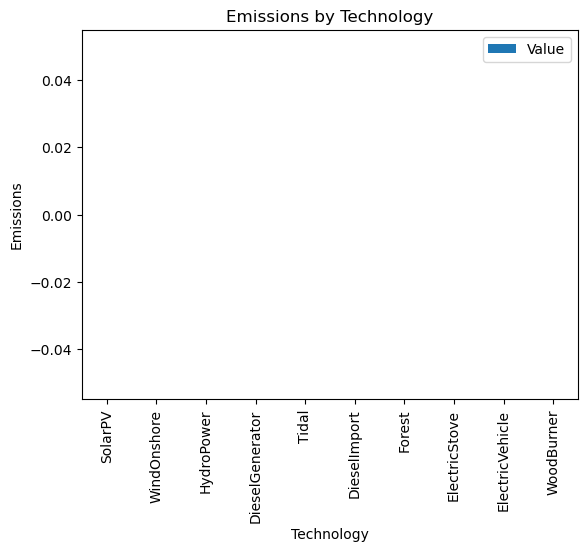

In [47]:
#seeing the emissions per technology
TechnologyEmissions = pd.DataFrame(instance.TechnologyEmissions.extract_values().values(), 
                                   index=pd.Index(instance.TechnologyEmissions.extract_values().keys(), name='Technology'), 
                                   columns=['Value']).reset_index()

TechnologyEmissions.plot(kind='bar', x='Technology', y='Value', title='Emissions by Technology')
plt.ylabel('Emissions')
plt.show()

### 2. Reverse Base Case

###### (We let the system build new capacities on top of existing capacities such that the demand sectors are all met)

In [48]:
#Enter your code here

### 3. Future Business As Usual

###### (We expand the reverse base case across 15 years)

In [49]:
#Enter your code here

### 4. Future with Energy Efficiency Measures

###### (We expand the reverse base case across 15 years)

In [50]:
#Enter your code here

### 5. Future with Peak-shifting

###### (We expand the reverse base case across 15 years)

In [51]:
#Enter your code here